In [1]:
import matplotlib.pyplot as mplt
from operator import itemgetter
from itertools import groupby
import numpy as np
import cv2
import ast
import csv
import os


# set matplotlib to print inline (Jupyter)
%matplotlib inline

pth = '../data/dump/'
files = os.listdir(pth)

def readDump(source):
    with open(pth + source, 'rb') as ff:
        out = ff.read()
        out = out.decode('utf-8')
        return out.split('\n')

def csvRead(file, filepth='../data/', delimiter=';'):
    with open(filepth + file, newline='') as csv_file:
        csv_data = csv.reader(csv_file, delimiter=delimiter)
        return list(csv_data)[1:]

def loadLittleInfo(csv_reader_out):
    clients = [int(data_point[2]) for data_point in csv_reader_out]
    little_info = np.array(clients)
    return little_info

def generateLocationMap(perimeter_info):
    alist = list()
    blist = list()
    for info in perimeter_info:
        if info[0] in alist:
            blist[alist.index(info[0])].append([int(info[1]), int(info[2])])
        else:
            alist.append(info[0])
            blist.append([[int(info[1]), int(info[2])]])
    locmap = [np.array(i) for i in blist]
    locmap = [(
        np.sum(i.transpose()[0]) // len(i.transpose()[0]),
        np.sum(i.transpose()[1]) // len(i.transpose()[1])) for i in locmap]

    relational_locmap = {k: v for k, v in zip(alist, locmap)}
    return relational_locmap


In [ ]:
bests = list()
for f in files:
    raw_data = readDump(f)[2:]
    sep_gens = [raw_data[i-4: i] for i in range(4, len(raw_data), 4)]
    gen_num = [int(j.split('***')[1]) for j in [i[0] for i in sep_gens]]
    gen_gen = [ast.literal_eval(i[1]) for i in sep_gens]
    gen_fit = [ast.literal_eval(i[2]) for i in sep_gens]
    gen_sur = [ast.literal_eval(i[3]) for i in sep_gens]
    
    # plotting data
    mplt.figure(figsize=(16, 7))
    mplt.title(f)
    mplt.ylim((0.25, 0.3))
    view_gens = [gen_num[i] for i in range(0, len(gen_num), 2)]
    view_gens.append(gen_num[-1])
    for i in view_gens:
        avg = 0
        for j in range(len(gen_fit[i])):
            avg += gen_fit[i][j]
            if j not in gen_sur[i]:
                mplt.scatter(gen_num[i], gen_fit[i][j], color='r')
            else:
                mplt.scatter(gen_num[i], gen_fit[i][j], color='y')
        avg = avg / len(gen_fit[i])
        mplt.scatter(gen_num[i], avg, color='b')
    mplt.scatter(gen_num[len(gen_num) - 1], min(gen_fit[len(gen_num) - 1]), color='g')
    l_gen = gen_gen[len(gen_num) - 1]
    l_fit = gen_fit[len(gen_num) - 1]
    bests.append((f, l_gen[l_fit.index(min(l_fit))]))


In [ ]:
def csvRead(file, filepth='../data/', delimiter=';'):
    with open(filepth + file, newline='') as csv_file:
        csv_data = csv.reader(csv_file, delimiter=delimiter)
        return list(csv_data)[1:]

def loadLittleInfo(csv_reader_out):
    clients = [int(data_point[2]) for data_point in csv_reader_out]
    little_info = np.array(clients)
    return little_info

cc = csvRead('neighborhood_description.csv')
info = loadLittleInfo(cc)

for f, best in bests:
    days = set(best)
    total_revisions = [
        sum(info[i] for i in range(len(best)) if best[i] == d)
        for d in days]
    
    avg = np.mean(total_revisions)
    
    mplt.figure(figsize=(10, 4))
    mplt.title(f)
    mplt.bar(list(days), total_revisions)
    mplt.plot([1, len(days)], [avg, avg], color="red")


In [ ]:
import json
per = csvRead('neighborhood_nodes.csv')
group = [[(int(x), int(y)) for n, x, y in g] for k, g in  groupby(per,key=itemgetter(0))]
loc = generateLocationMap(per)

labels = list()
for i in per:
    if i[0] not in labels:
        labels.append(i[0])

loc = [loc[k] for k in labels]

# Find maximas and minimas
norm_x = 640
norm_y = 480
max_x = 0
min_x = 99999999
max_y = 0
min_y = 99999999

colors = [
    [0, 86, 226],  # 1
    [163, 198, 255],  # 2
    [19, 29, 45],  # 3
    [0, 255, 225],  # 4
    [0, 130, 114],  # 5
    [6, 130, 0],  # 6
    [11, 255, 0],  # 7
    [135, 255, 130],  # 8
    [248, 255, 130],  # 9
    [240, 255, 0],  # 10
    [127, 135, 0],  # 11
    [255, 80, 0],  # 12
    [255, 0, 0],  # 13
    [203, 0, 255],  # 14
    [75, 0, 94],  # 15
    [140, 140, 140],  # 16
    [0, 0, 0],  # 17
    [255, 73, 155],  # 18
    [107, 51, 0], # 19
    [87, 107, 0],  # 20
]

colors = [np.array(color, dtype=np.uint8) for color in colors]


for i in group:
    xs = [a for a, b in i]
    ys = [b for a, b in i]

    if max_x < max(xs):
        max_x = max(xs)
    if max_y < max(ys):
        max_y = max(ys)
        
    if min_x > min(xs):
        min_x = min(xs)
    if min_y > min(ys):
        min_y = min(ys)

# Keep the scale factor unchanged
diff_x = max_x - min_x
diff_y = max_y - min_y

# Ratio w:h
ratio = diff_x / diff_y

usable_x = norm_x
usable_y = norm_y
if ratio < 1:
    usable_y = norm_y
    usable_x = int(norm_y * ratio)
    
img_px_sup = usable_x + 10
img_px_inf = 10

img_py_sup = 480 // 2 + usable_y // 2
img_py_inf = 480 // 2 - usable_y // 2

# Remap the values of group
def scaler(x, y):
    sx = ((img_px_sup - img_px_inf) * (x - min_x)) / (max_x - min_x) + img_px_inf
    sy = ((img_py_sup - img_py_inf) * (y - min_y)) / (max_y - min_y) + img_py_inf
    return (int(sx), int(sy))
group_scaled = [[scaler(x, y) for x, y in g] for g in group]
loc = [scaler(x, y) for x, y in loc]

# Create the image
img = np.zeros([481, img_px_sup + 11, 3], dtype=np.uint8)
img += np.array([255, 255, 255], dtype=np.uint8)

ccc = [np.array([i,j,0]) for i in range(10, 255, 10) for j in range(0, 255, 10)]
ccc = ccc[0:329]

cccc = list(zip(labels, ccc))
cccc = [(l, list(c)) for l, c in cccc]
cccc = [(l, [int(c[0]),int(c[1]),int(c[2])]) for l, c in cccc]
cccc = {k:c for k, c in cccc}
with open('color_relations.json', 'w') as outfile:
    json.dump(cccc, outfile, indent=4)

# 15
k = 15

for g in group_scaled:
    for i in g:
        img[i[1], i[0]] = np.array([220, 220, 220], dtype=np.uint8)
for i in group_scaled[k]:
        img[i[1], i[0]] = colors[0]
print(ccc[k])

img[loc[k][1]:loc[k][1]+5, loc[k][0]:loc[k][0]+5] = ccc[k]

mplt.figure(figsize=(27, 30))
mplt.imshow(img, origin='lower')
# mplt.savefig('holi.png')

In [ ]:
import cv2
import matplotlib.pyplot as mplt
# set matplotlib to print inline (Jupyter)
%matplotlib inline

img = 'mapa.png'
img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
img_c = img.copy()

h, w = img.shape

for i in range(h-1):
    for j in range(w-1):
        if img[i,j] == 0:
            if img[i+1,j+1] == 0 or img[i-1,j+1] == 0:
                img_c[i,j+1] = 0
            elif img[i-1,j-1] == 0 or img[i+1,j-1] == 0:
                img_c[i,j-1] = 0

cv2.imwrite('holi.png', img_c)
mplt.figure(figsize=(20,20))
mplt.imshow(img_c, cmap='gray')
mplt.show()

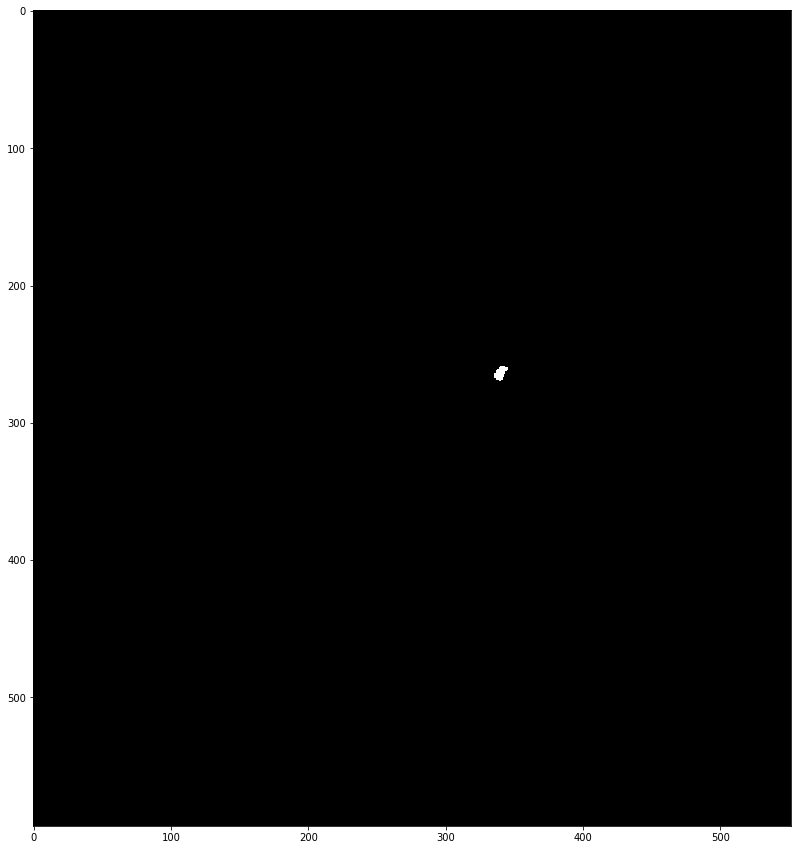

In [34]:
img = 'mapa_color.png'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

neighbor = np.zeros(img.shape)
neighbor = np.all(img == [10, 0, 0], axis=-1)
neighbor = np.stack([neighbor, neighbor, neighbor], axis=2)
neighbor = np.where(neighbor, [255, 255, 255], neighbor)

neighbor = neighbor.astype(np.uint8)

mplt.figure(figsize=(15,15))
mplt.imshow(neighbor, vmin=0)
mplt.show()